# Neural Network

In [30]:
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

import yaml

import matplotlib.pyplot as plt

In [31]:
hparams = yaml.safe_load(open('../src/models/hparams.yaml'))

hparams

{'learning_rate': 0.01, 'batch_size': 16, 'num_hidden_layers': 4}

In [32]:
wiki_df = pd.read_csv('../data/processed/wiki_df.csv', sep=';')

wiki_df.head()

,full_path,gender,age,img_array
0,17/10000217_1981-05-05_2009.jpg,1.0,28,[255 255 255 ... 144 78 27]
1,12/100012_1948-07-03_2008.jpg,1.0,60,[92 98 93 ... 35 31 30]
2,16/10002116_1971-05-31_2012.jpg,0.0,41,[ 10 30 61 ... 231 237 255]
3,02/10002702_1960-11-09_2012.jpg,0.0,52,[178 122 97 ... 168 112 83]
4,41/10003541_1937-09-27_1971.jpg,1.0,34,[194 189 190 ... 101 103 104]


In [33]:
# Noramalize image values on range <0.0;1.0>
# check: https://www.tensorflow.org/tutorials/images/cnn
#wiki_df['img_array'] = wiki_df['img_array'] / 255.0
#wiki_df.head()

In [54]:
import cv2

wiki_df['img_array'] = wiki_df['full_path'].apply(lambda x: np.array(cv2.resize(cv2.imread('../data/raw/wiki_crop/' + x), (224, 224), interpolation=cv2.INTER_LINEAR).reshape(1, -1)[0]))

## Experiment 1

* Ako prvé sa pokúsime vytvoriť NN podobnú VGG. Podľa [WEEK_7 lab](https://github.com/matus-pikuliak/neural_networks_at_fiit/blob/92b24eef8e6444c43a22e8fa51a349b3b1043a7c/week_7/week_7.ipynb), alebo iného tutoriálu
* Natrénujeme ju na už predspracovanom datasete
* Jej výsledok pou%zijeme ako štartovaciu čiaru
* Túto sieť budeme rozširovať o ďalšie vrstvy a parametre
* V projekte ponecháme sieť s najlepším skóre
* Dole pripájam referenčnú ukážku siete. [Zdroj](https://www.pyimagesearch.com/2019/10/28/3-ways-to-create-a-keras-model-with-tensorflow-2-0-sequential-functional-and-model-subclassing/?__s)

In [37]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten
from tensorflow.keras.layers import Activation, BatchNormalization, Dropout


class MiniVGGNetModel(keras.Model):
    def __init__(self, classes, chanDim=-1):
        # call the parent constructor
        super(MiniVGGNetModel, self).__init__()

        # initialize the layers in the first (CONV => RELU) * 2 => POOL
        # layer set
        self.conv1A = Conv2D(32, (3, 3), padding="same")
        self.act1A = Activation("relu")
        self.bn1A = BatchNormalization(axis=chanDim)
        self.conv1B = Conv2D(32, (3, 3), padding="same")
        self.act1B = Activation("relu")
        self.bn1B = BatchNormalization(axis=chanDim)
        self.pool1 = MaxPooling2D(pool_size=(2, 2))

        # initialize the layers in the second (CONV => RELU) * 2 => POOL
        # layer set
        self.conv2A = Conv2D(32, (3, 3), padding="same")
        self.act2A = Activation("relu")
        self.bn2A = BatchNormalization(axis=chanDim)
        self.conv2B = Conv2D(32, (3, 3), padding="same")
        self.act2B = Activation("relu")
        self.bn2B = BatchNormalization(axis=chanDim)
        self.pool2 = MaxPooling2D(pool_size=(2, 2))

        # initialize the layers in our fully-connected layer set
        self.flatten = Flatten()
        self.dense3 = Dense(512)
        self.act3 = Activation("relu")
        self.bn3 = BatchNormalization()
        self.do3 = Dropout(0.5)

        # initialize the layers in the softmax classifier layer set
        self.dense4 = Dense(classes)
        self.softmax = Activation("softmax")

    def call(self, inputs):
        # build the first (CONV => RELU) * 2 => POOL layer set
        x = self.conv1A(inputs)
        x = self.act1A(x)
        x = self.bn1A(x)
        x = self.conv1B(x)
        x = self.act1B(x)
        x = self.bn1B(x)
        x = self.pool1(x)

        # build the second (CONV => RELU) * 2 => POOL layer set
        x = self.conv2A(x)
        x = self.act2A(x)
        x = self.bn2A(x)
        x = self.conv2B(x)
        x = self.act2B(x)
        x = self.bn2B(x)
        x = self.pool2(x)

        # build our FC layer set
        x = self.flatten(x)
        x = self.dense3(x)
        x = self.act3(x)
        x = self.bn3(x)
        x = self.do3(x)

        # build the softmax classifier
        x = self.dense4(x)
        x = self.softmax(x)

        # return the constructed model
        return x

In [38]:
target = wiki_df['age'].values


In [56]:
classes = 101 #0 to 100
target = wiki_df['age'].values
target_classes = keras.utils.to_categorical(target, classes)

features = [] 
for i in range(0, len(wiki_df['img_array'].values)):
    features.append(wiki_df['img_array'].values[i])
 
features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)

#features = wiki_df['img_array'].values
#features = features / 255.0
#features = features.reshape(features.shape[0], 224, 224, 3)

MemoryError: Unable to allocate array with shape (22578, 150528) and data type uint8

In [40]:
print(len(wiki_df['img_array'].values))
print(len(target_classes))
print(len(features))
print((features.shape))

22578
22578
22578
(22578, 224, 224, 3)


In [51]:
split = int(22578/2)

train_images = features[0:split]
#train_images = train_images / 255.0
train_labels = target_classes[0:split]

test_images = features[split:]
#test_images = test_images / 255.0
test_labels = target_classes[split:]

In [57]:
HACK = int(22578/6)

for i in range(6):
    start = i*HACK
    end = (i+1)*HACK
    
    train_images[start:end] = train_images[start:end] / 255.0
    test_images[start:end] = test_images[start:end] / 255.0

MemoryError: Unable to allocate array with shape (3763, 224, 224, 3) and data type float64

In [55]:
test_images[150]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

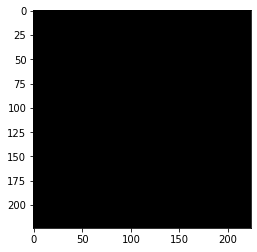

In [48]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(test_images[0])
plt.show()

In [49]:
model = MiniVGGNetModel(
    classes = classes)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

callbacks = [
    #keras.callbacks.TensorBoard(
    #    log_dir=os.path.join("logs", timestamp()),
    #    histogram_freq=1,
    #    profile_batch=0)
]

# callbacks = []  # If you do not want to log results into TensorBoard

scores = []
epochs = 60
batch_size = 64

score = model.fit(
    x=train_images,
    y=train_labels,
    batch_size = batch_size,
    validation_data = (test_images, test_labels),
    callbacks = callbacks,
    epochs = epochs)

scores.append(score)

model.summary()  # Writes number of parameters for each layer at the end of the training

TypeError: in converted code:

    <ipython-input-37-7fe3c9ba7f72>:43 call  *
        x = self.conv1A(inputs)
    /home/viliam/.virtualenvs/neural_networks_at_fiit/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py:842 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /home/viliam/.virtualenvs/neural_networks_at_fiit/lib/python3.6/site-packages/tensorflow_core/python/keras/layers/convolutional.py:197 call
        outputs = self._convolution_op(inputs, self.kernel)
    /home/viliam/.virtualenvs/neural_networks_at_fiit/lib/python3.6/site-packages/tensorflow_core/python/ops/nn_ops.py:1134 __call__
        return self.conv_op(inp, filter)
    /home/viliam/.virtualenvs/neural_networks_at_fiit/lib/python3.6/site-packages/tensorflow_core/python/ops/nn_ops.py:639 __call__
        return self.call(inp, filter)
    /home/viliam/.virtualenvs/neural_networks_at_fiit/lib/python3.6/site-packages/tensorflow_core/python/ops/nn_ops.py:238 __call__
        name=self.name)
    /home/viliam/.virtualenvs/neural_networks_at_fiit/lib/python3.6/site-packages/tensorflow_core/python/ops/nn_ops.py:2010 conv2d
        name=name)
    /home/viliam/.virtualenvs/neural_networks_at_fiit/lib/python3.6/site-packages/tensorflow_core/python/ops/gen_nn_ops.py:1071 conv2d
        data_format=data_format, dilations=dilations, name=name)
    /home/viliam/.virtualenvs/neural_networks_at_fiit/lib/python3.6/site-packages/tensorflow_core/python/framework/op_def_library.py:631 _apply_op_helper
        param_name=input_name)
    /home/viliam/.virtualenvs/neural_networks_at_fiit/lib/python3.6/site-packages/tensorflow_core/python/framework/op_def_library.py:60 _SatisfiesTypeConstraint
        ", ".join(dtypes.as_dtype(x).name for x in allowed_list)))

    TypeError: Value passed to parameter 'input' has DataType uint8 not in list of allowed values: float16, bfloat16, float32, float64


# Experiment 2
Cely VGG model.

Zdroj: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/

In [5]:
model = keras.models.Sequential()
model.add(keras.layers.ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(keras.layers.Convolution2D(64, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2)))
 
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(128, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2)))
 
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(256, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(256, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(256, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2)))
 
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2)))
 
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2)))
 
model.add(keras.layers.Convolution2D(4096, (7, 7), activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Convolution2D(4096, (1, 1), activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Convolution2D(2622, (1, 1)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Activation('softmax'))

In [7]:
model.load_weights('../data/vgg_face_weights.h5')

In [45]:
vgg_face_descriptor = keras.Model(inputs=model.layers[0].input, outputs=model.layers[-1].output)

Convert image as array using opencv

In [59]:
classes = 101 #0 to 100
target = wiki_df['age'].values
target_classes = keras.utils.to_categorical(target, classes)

features = []
 
for i in range(0, 1):
    features.append(wiki_df['img_array'].values[i])
 
features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)

In [54]:
for layer in model.layers[:-7]:
    layer.trainable = False

In [56]:
base_model_output = keras.models.Sequential()
base_model_output = keras.layers.Convolution2D(101, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = keras.layers.Flatten()(base_model_output)
base_model_output = keras.layers.Activation('softmax')(base_model_output)

In [58]:
age_model = keras.Model(inputs=model.input, outputs=base_model_output)

In [63]:
age_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
 
scores = []
epochs = 250; batch_size = 256
 
for i in range(epochs):
    print("epoch ",i)
 
ix_train = np.random.choice(train_x.shape[0], size=batch_size)
 
score = age_model.fit(train_x[ix_train], train_y[ix_train], epochs=1, validation_data=(test_x, test_y))
 
scores.append(score)

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29
epoch  30
epoch  31
epoch  32
epoch  33
epoch  34
epoch  35
epoch  36
epoch  37
epoch  38
epoch  39
epoch  40
epoch  41
epoch  42
epoch  43
epoch  44
epoch  45
epoch  46
epoch  47
epoch  48
epoch  49
epoch  50
epoch  51
epoch  52
epoch  53
epoch  54
epoch  55
epoch  56
epoch  57
epoch  58
epoch  59
epoch  60
epoch  61
epoch  62
epoch  63
epoch  64
epoch  65
epoch  66
epoch  67
epoch  68
epoch  69
epoch  70
epoch  71
epoch  72
epoch  73
epoch  74
epoch  75
epoch  76
epoch  77
epoch  78
epoch  79
epoch  80
epoch  81
epoch  82
epoch  83
epoch  84
epoch  85
epoch  86
epoch  87
epoch  88
epoch  89
epoch  90
epoch  91
epoch  92
epoch  93
epoch  94
epoch  95
epoch  96
epoch  97
epoch  98
epoch  99
epoch  100

KeyboardInterrupt: 